In [310]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 50)
pd.set_option('display.max_columns',50)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score

from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


In [12]:
df = pd.read_csv("loan_tap_logistic_regression.csv")

In [13]:
df.shape

(396030, 27)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [5]:
## Number of Null values
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [6]:
df.loan_status.value_counts()

loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64

In [24]:
## data is highly imbalanced.
318357/(77673+318357)

0.8038709188697826

In [27]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [69]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,earliest_cr_line_converted,issue_d_converted,vintage_months
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",1990-06-01,2015-01-01,295
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",2004-07-01,2015-01-01,126
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",2007-08-01,2015-01-01,89
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813",2006-09-01,2014-11-01,98
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650",1999-03-01,2013-04-01,169


### Univariate Analysis

In [77]:
df['earliest_cr_line_converted'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y').dt.to_period('M').dt.to_timestamp()
df['issue_d_converted'] = pd.to_datetime(df['issue_d'],format = '%b-%Y').dt.to_period('M').dt.to_timestamp()
df['vintage_months'] = (df['issue_d_converted'].dt.year - df['earliest_cr_line_converted'].dt.year) * 12 + (df['issue_d_converted'].dt.month - df['earliest_cr_line_converted'].dt.month)

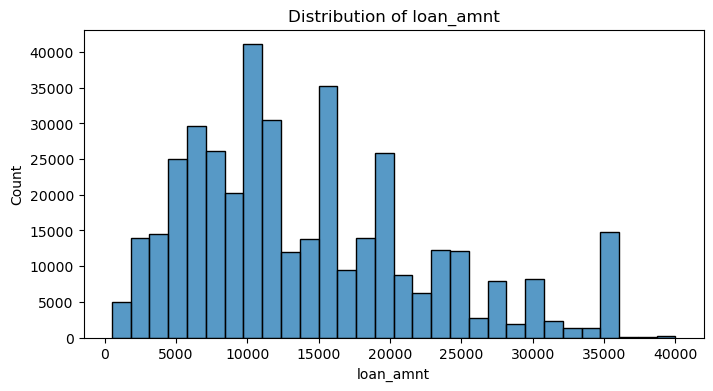

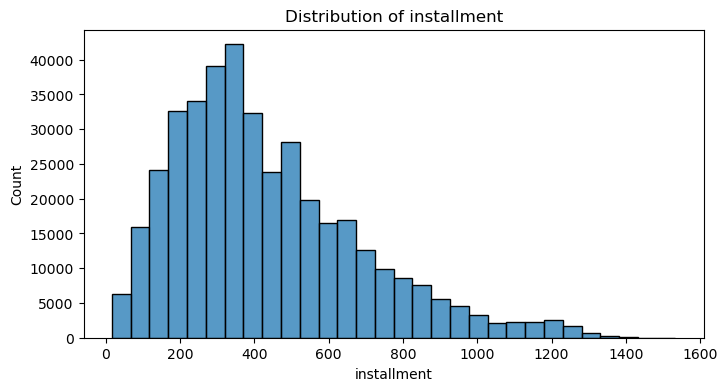

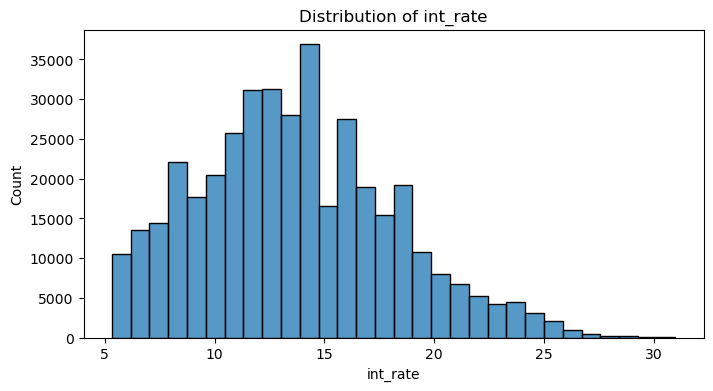

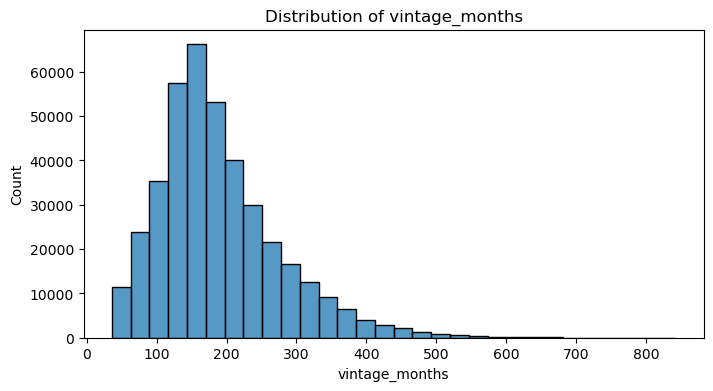

In [78]:
continuous_vars1 = ['loan_amnt', 'installment','int_rate','vintage_months']
for col in continuous_vars1:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

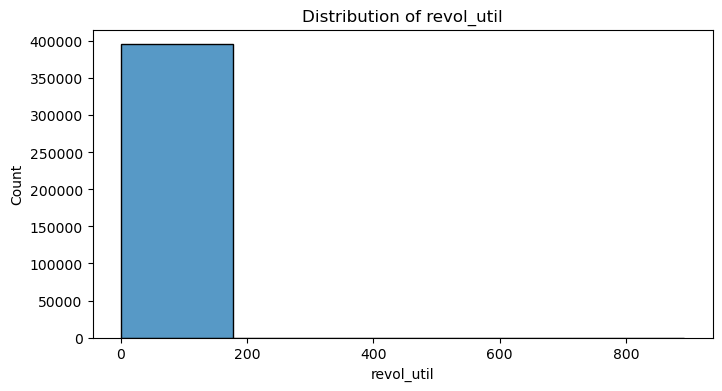

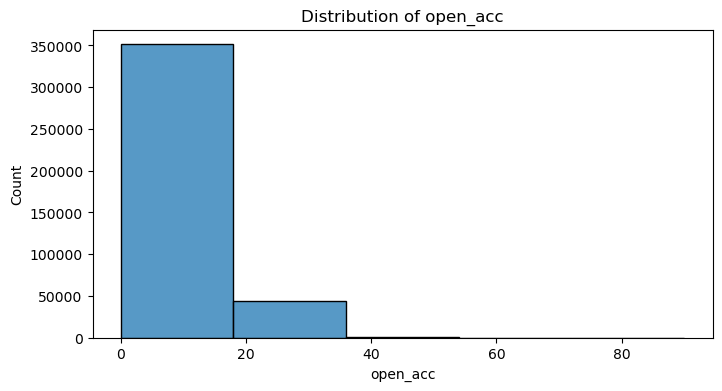

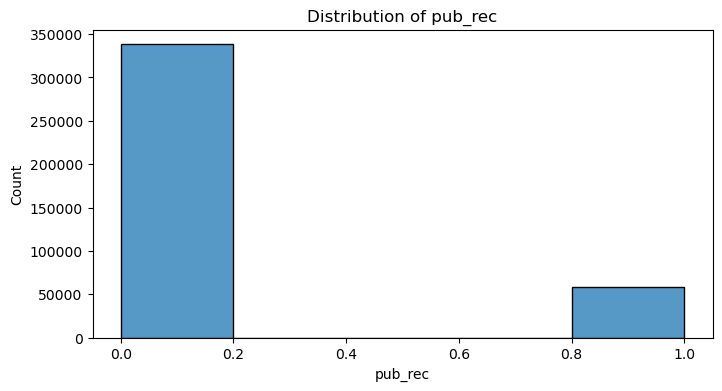

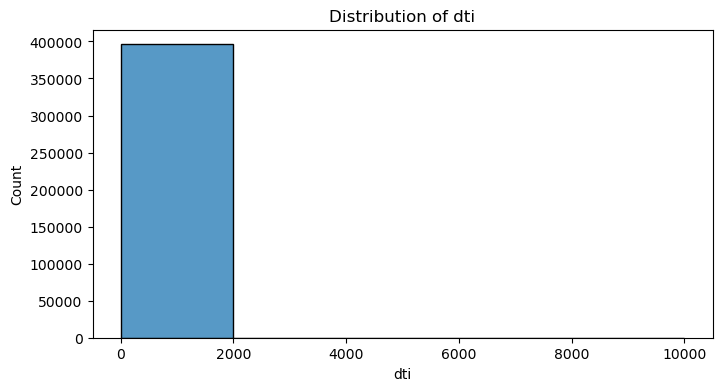

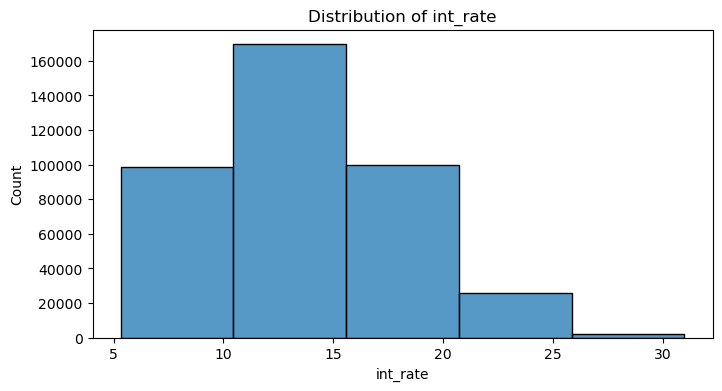

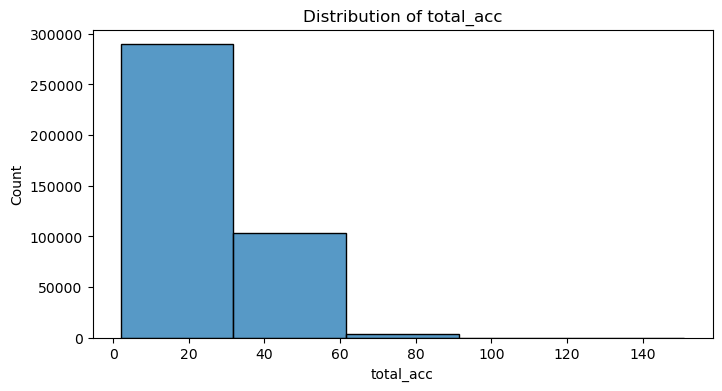

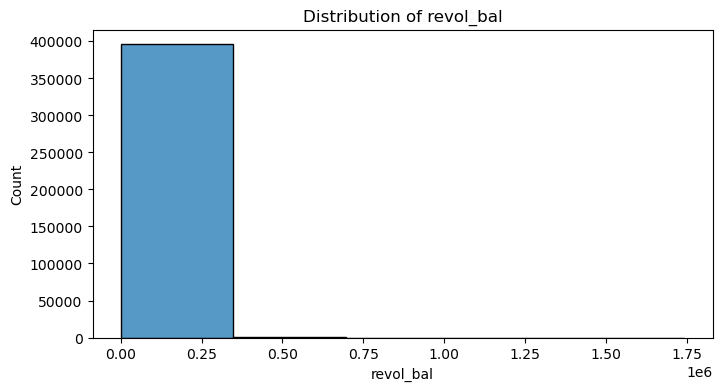

In [ ]:
continuous_vars2 = ['revol_util', 'open_acc', 'pub_rec', 'dti','total_acc','revol_bal']
for col in continuous_vars2:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=5)
    plt.title(f'Distribution of {col}')
    plt.show()

In [147]:
df.emp_title.value_counts().reset_index().head(10)

,emp_title,count
0,Teacher,4389
1,Manager,4250
2,Registered Nurse,1856
3,RN,1846
4,Supervisor,1830
5,Sales,1638
6,Project Manager,1505
7,Owner,1410
8,Driver,1339
9,Office Manager,1218


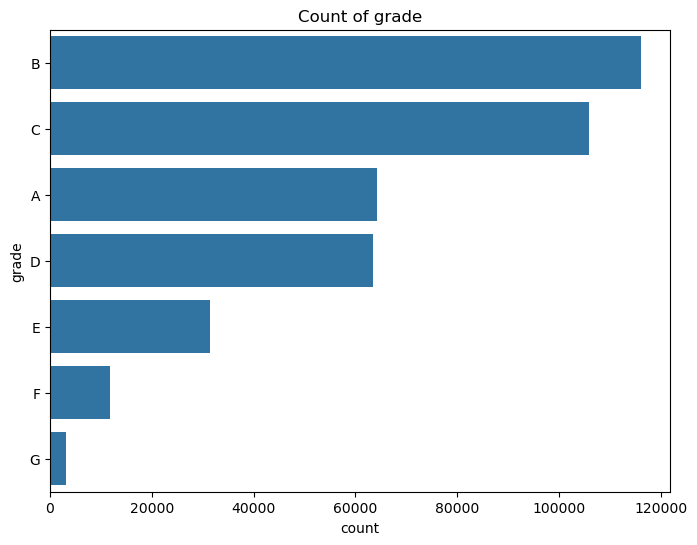

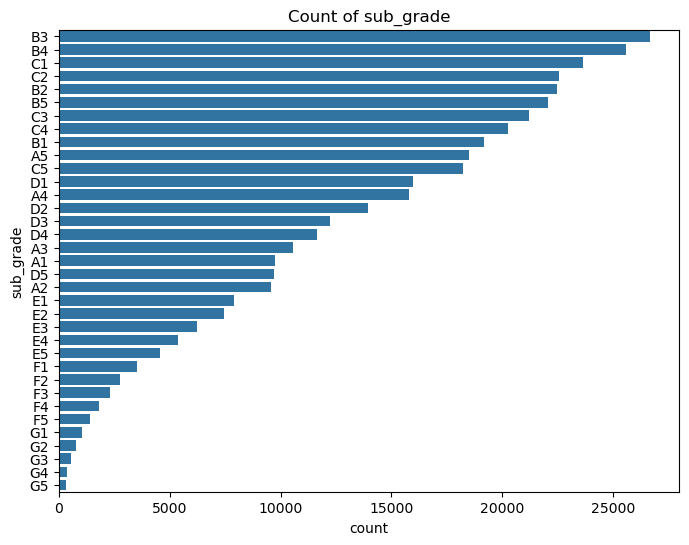

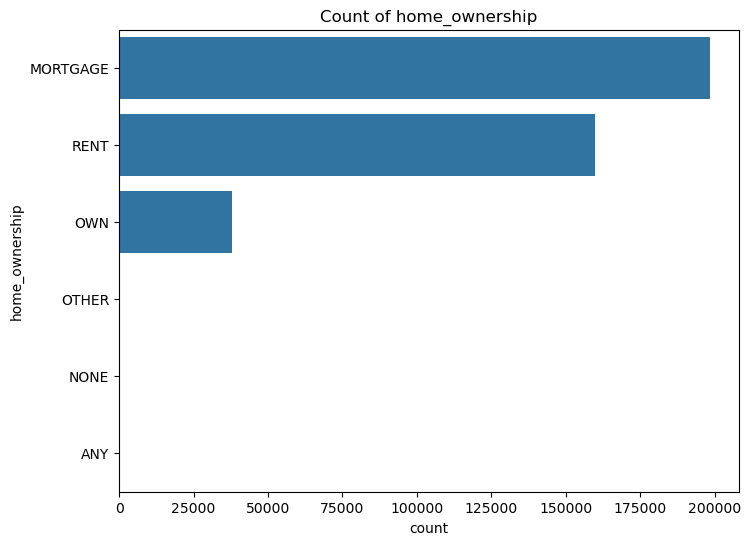

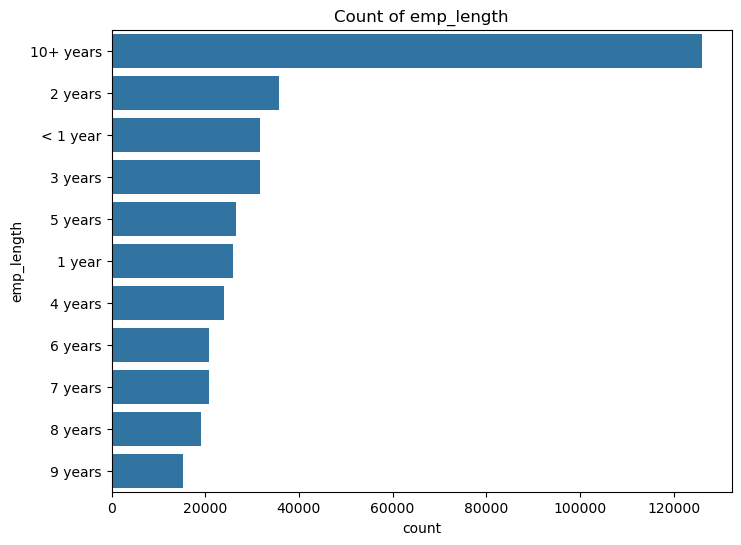

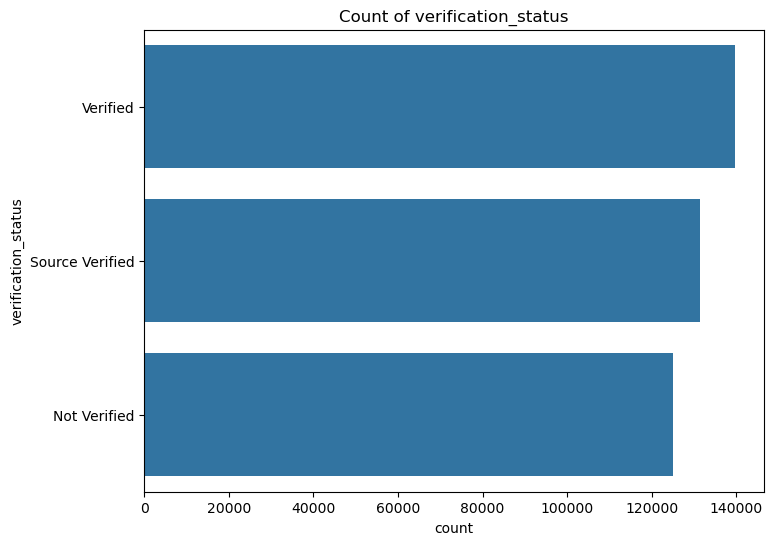

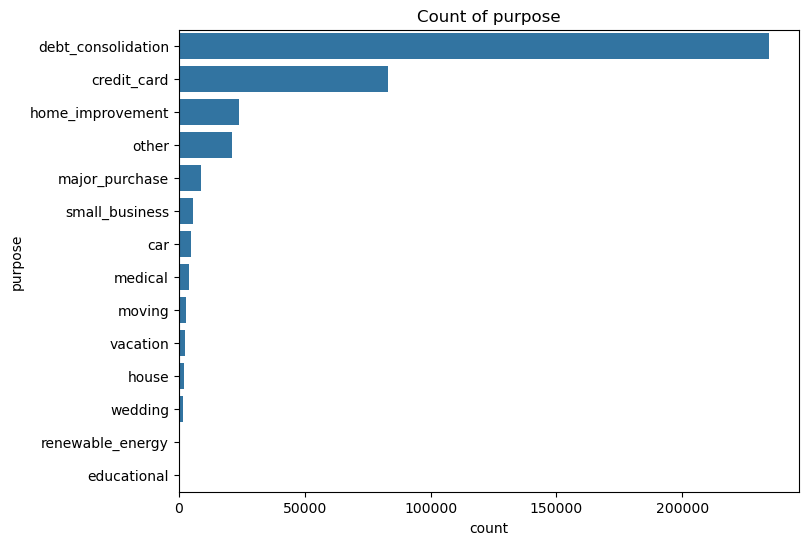

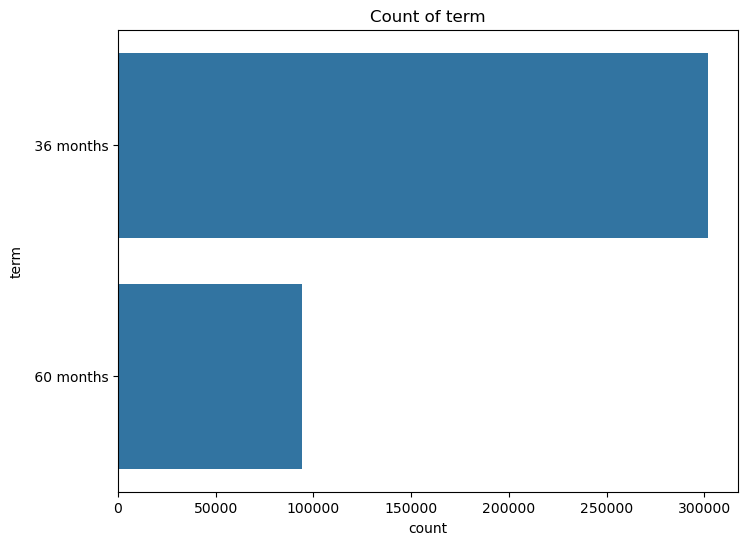

In [148]:
categorical_vars = ['grade', 'sub_grade', 'home_ownership', 'emp_length', 'verification_status', 'purpose','term']
for col in categorical_vars:
    plt.figure(figsize=(8,6))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.show()

In [ ]:
continuous_vars = continuous_vars1+continuous_vars2 
for col in continuous_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


### Bivariate Analysis (Target vs Features)

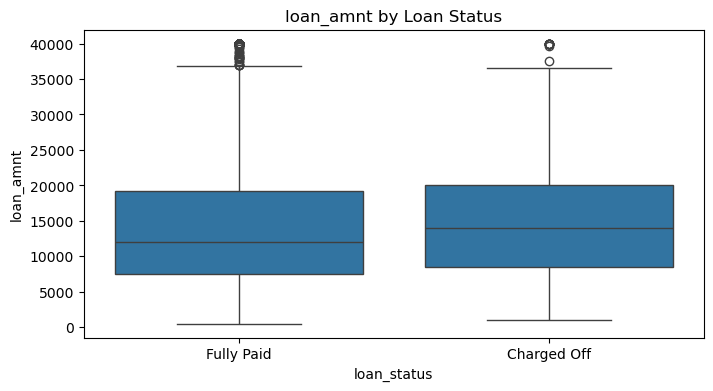

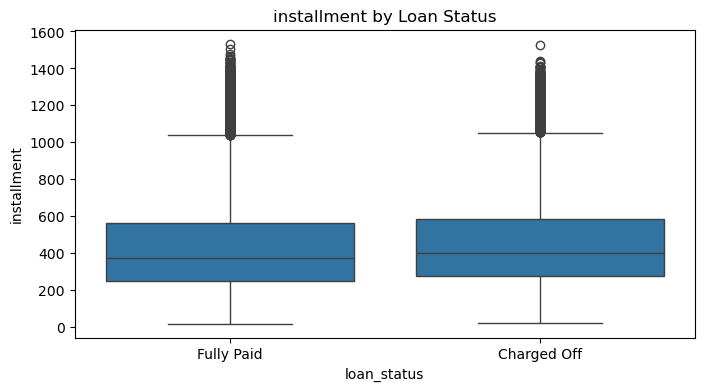

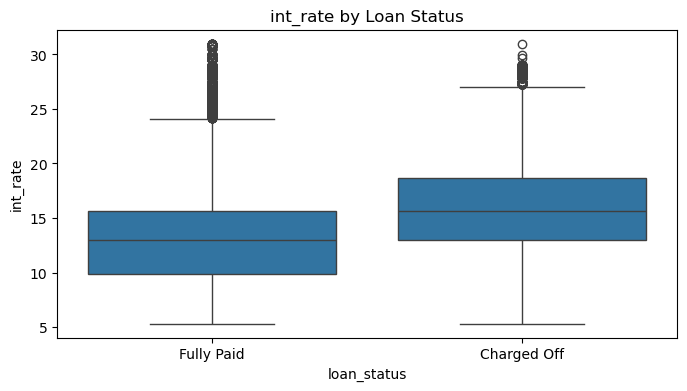

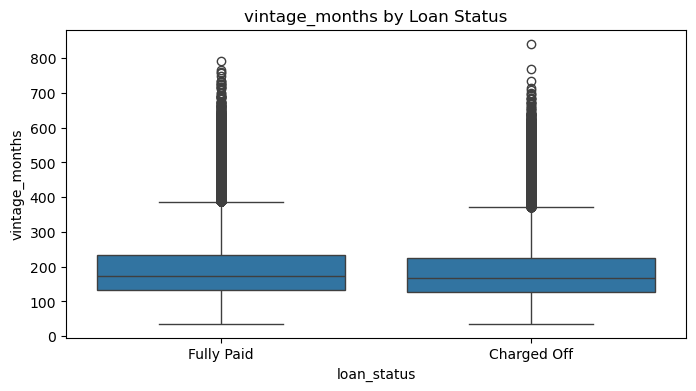

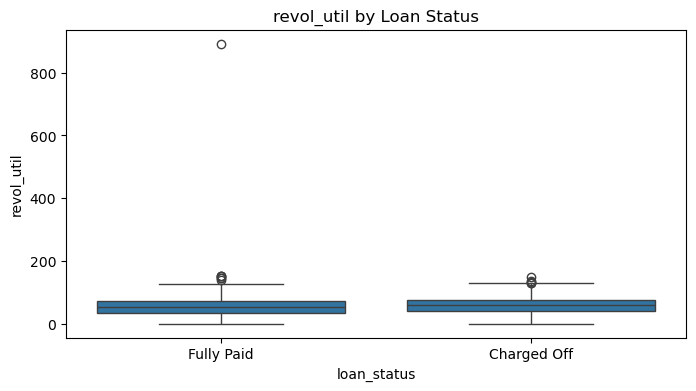

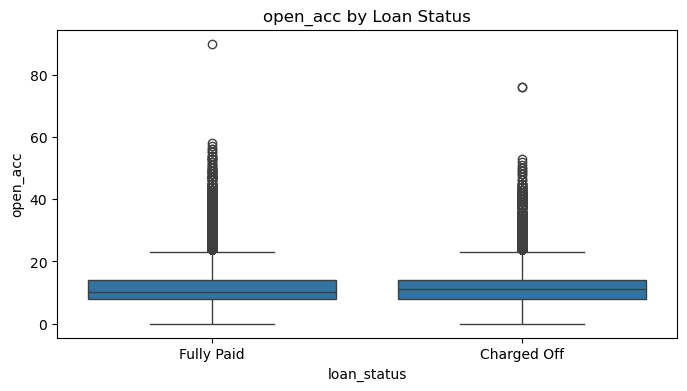

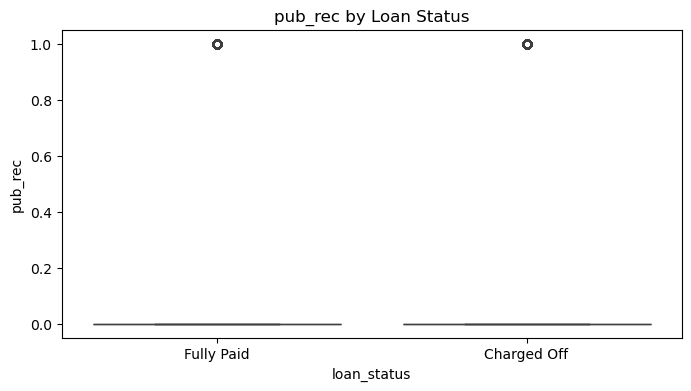

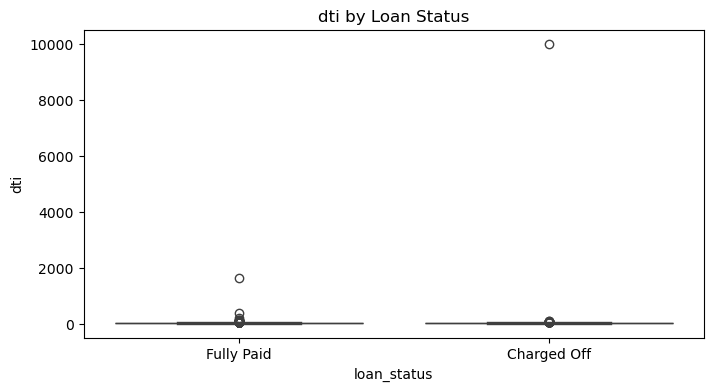

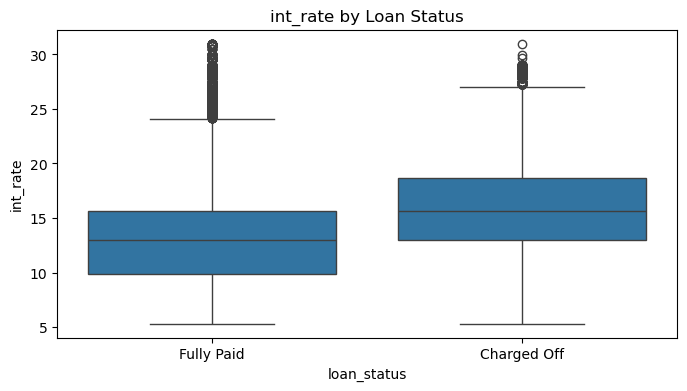

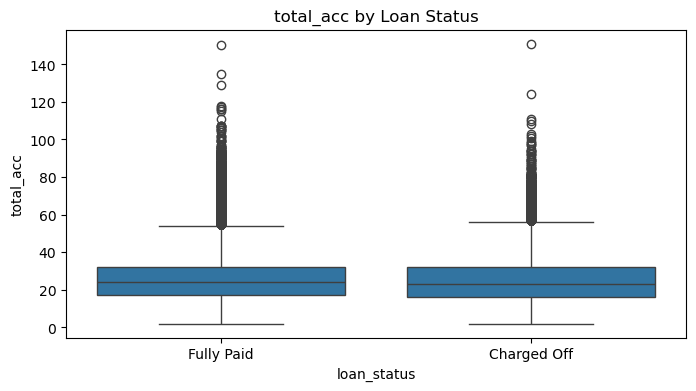

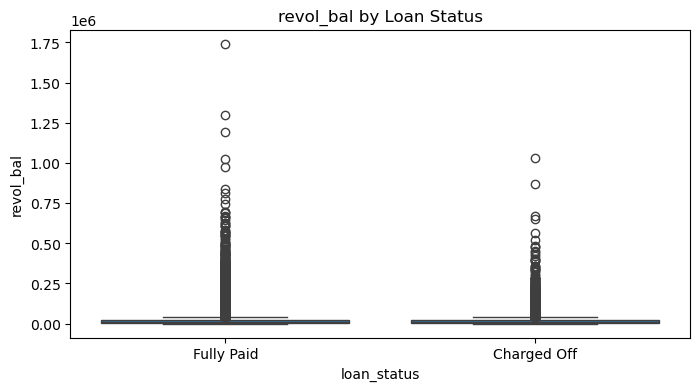

In [150]:
for col in continuous_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f'{col} by Loan Status')
    plt.show()

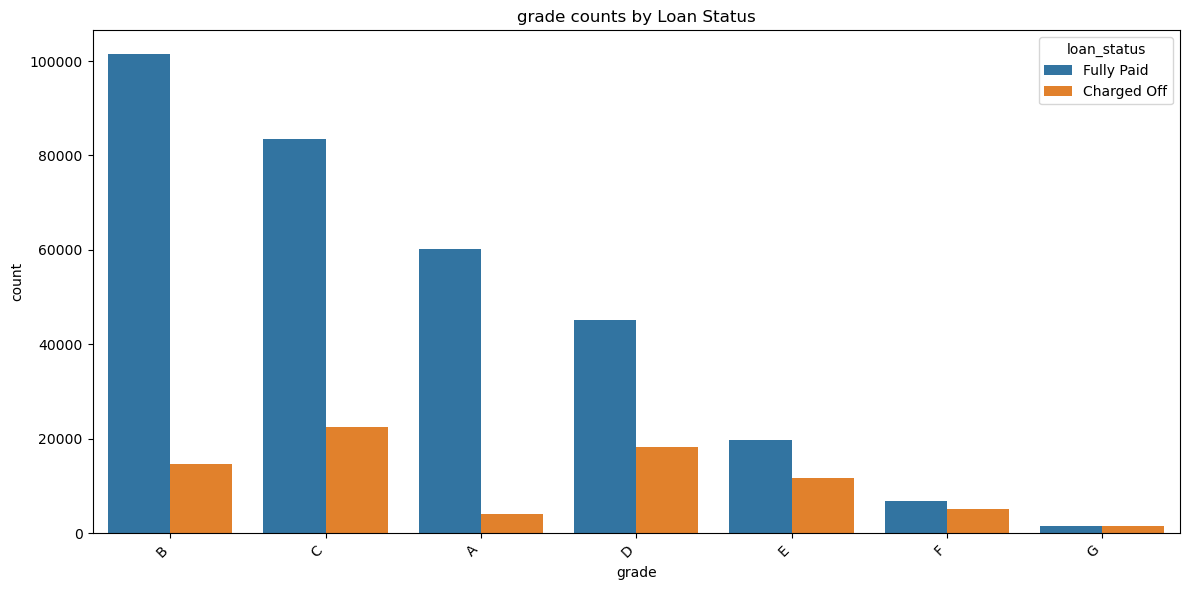

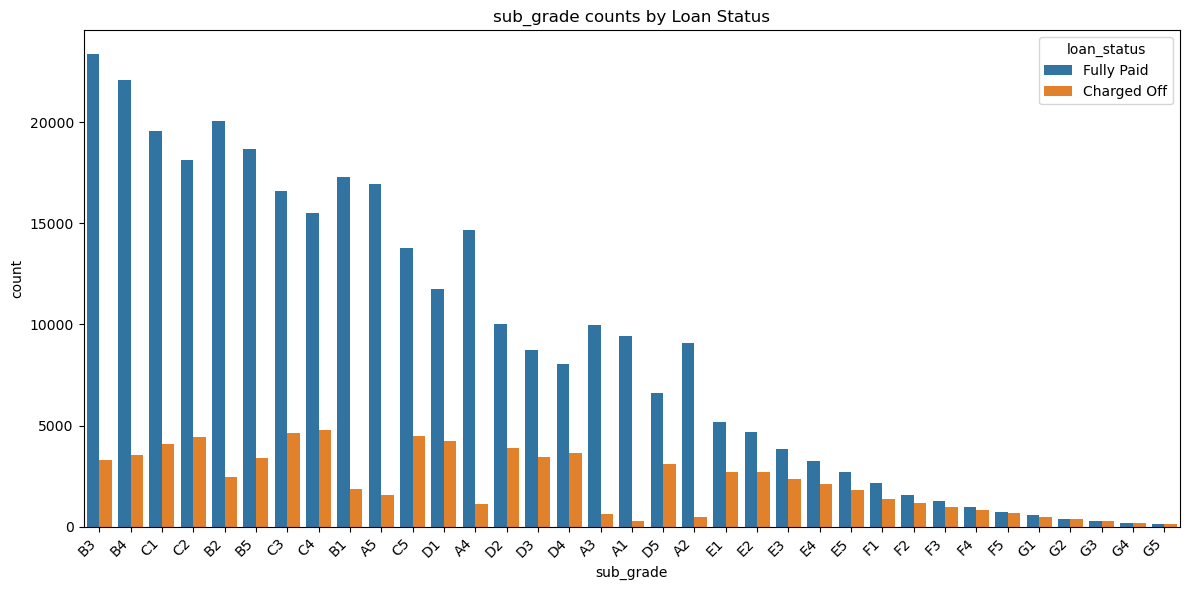

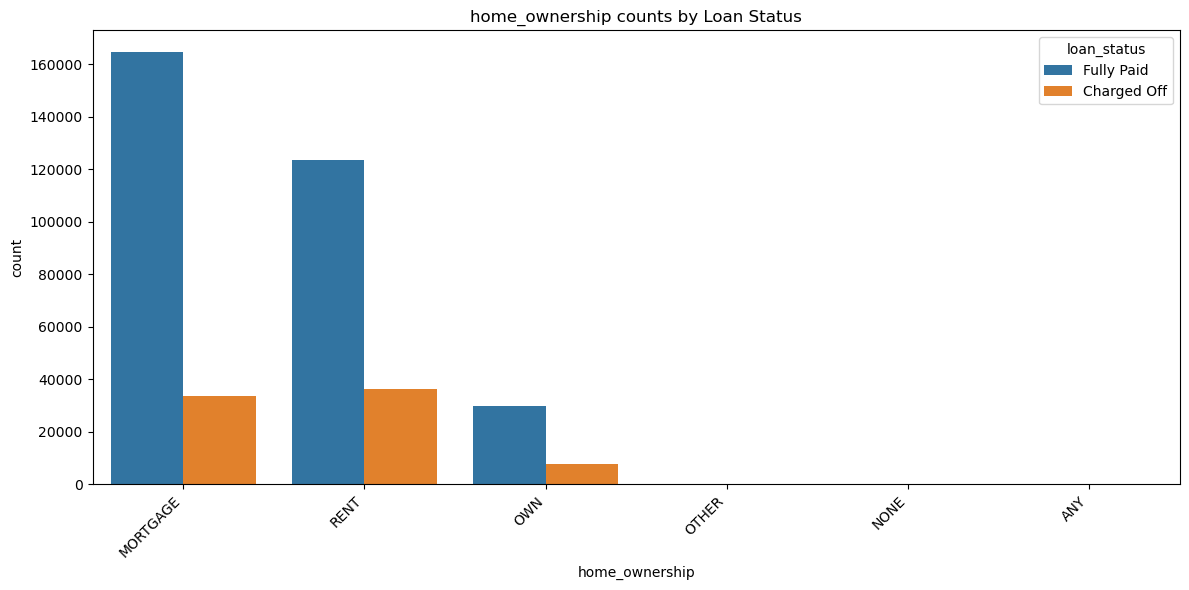

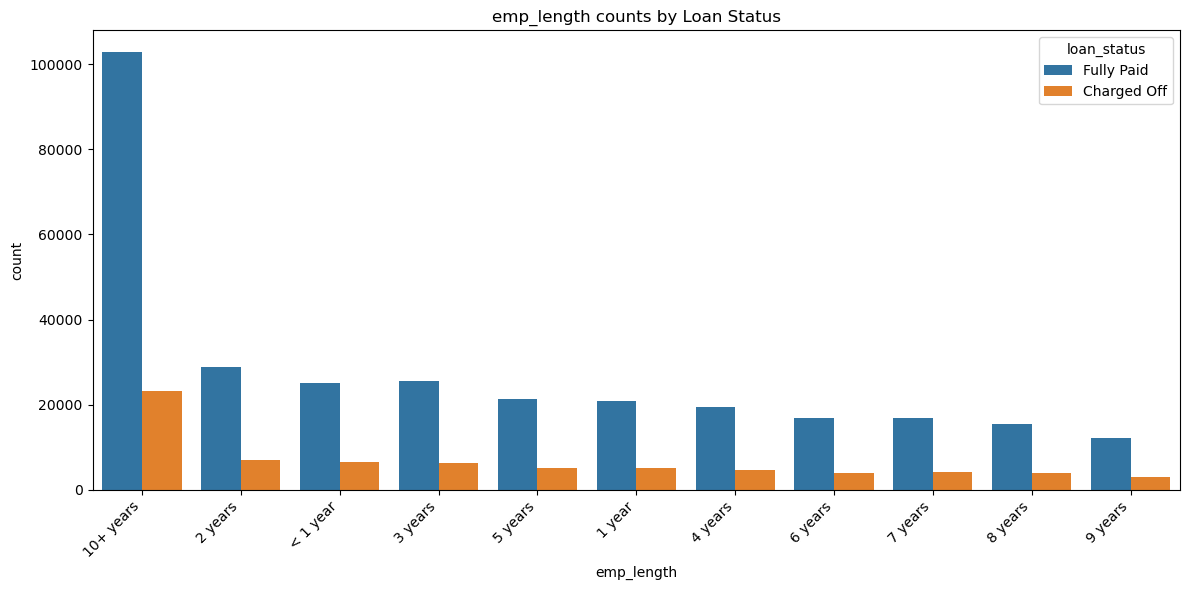

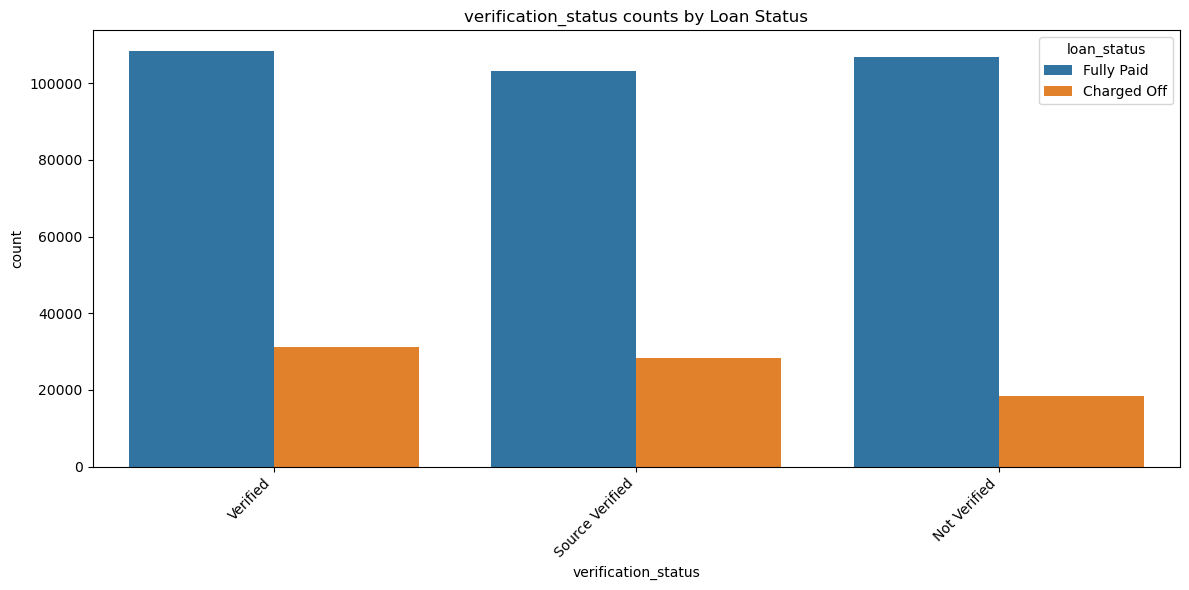

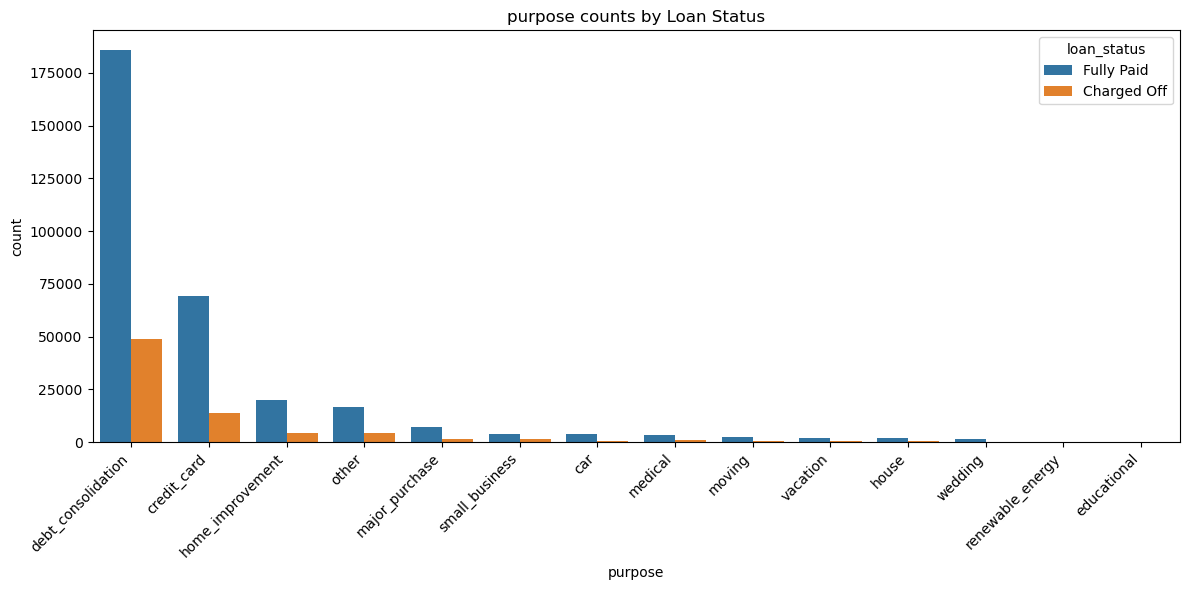

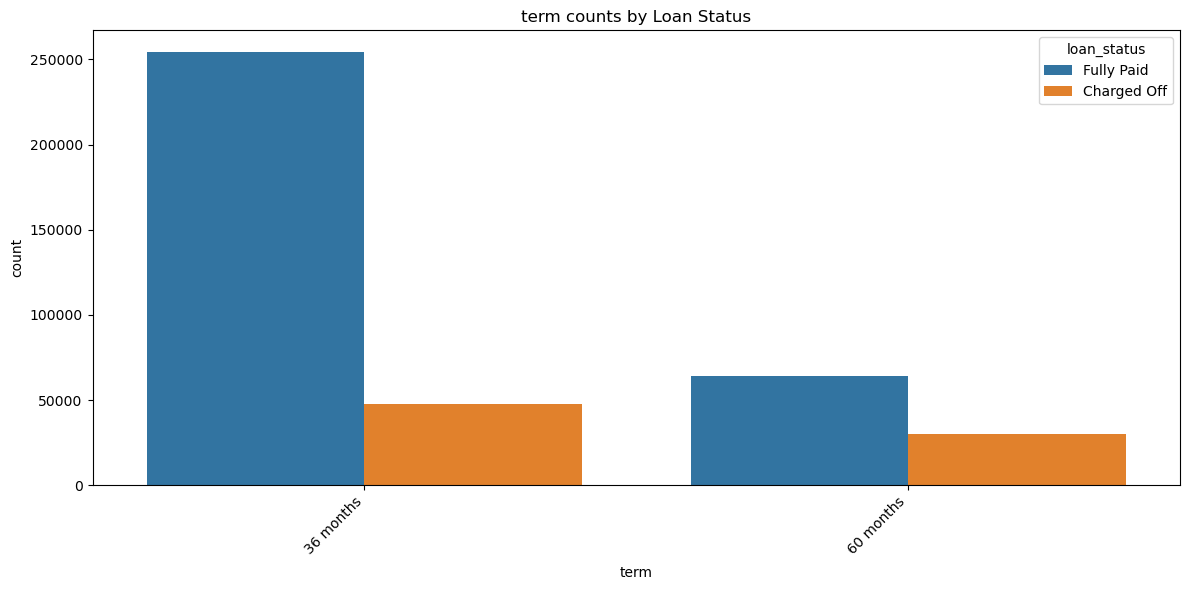

In [151]:
for col in categorical_vars:
    plt.figure(figsize=(12,6))  # wider figure helps
    sns.countplot(x=col, hue='loan_status', data=df, order=df[col].value_counts().index)
    plt.title(f'{col} counts by Loan Status')
    plt.xticks(rotation=45, ha='right')  # rotate labels 45 degrees, align right
    plt.tight_layout()  # adjusts plot to fit rotated labels
    plt.show()


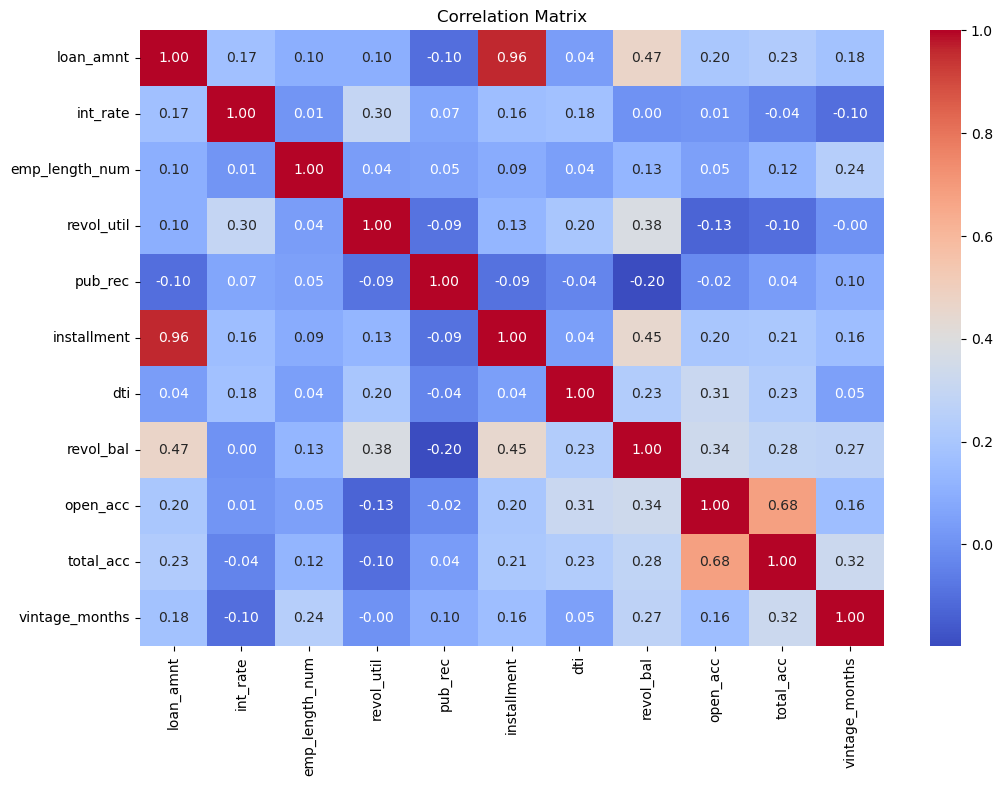

In [181]:
plt.figure(figsize=(12,8))
sns.heatmap(df[continuous_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Data Preprocessing and feature engineering

In [153]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [154]:
df['pub_rec']=df.pub_rec.apply(pub_rec)

df['mort_acc']=df.mort_acc.apply(mort_acc)

df['pub_rec_bankruptcies']=df.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

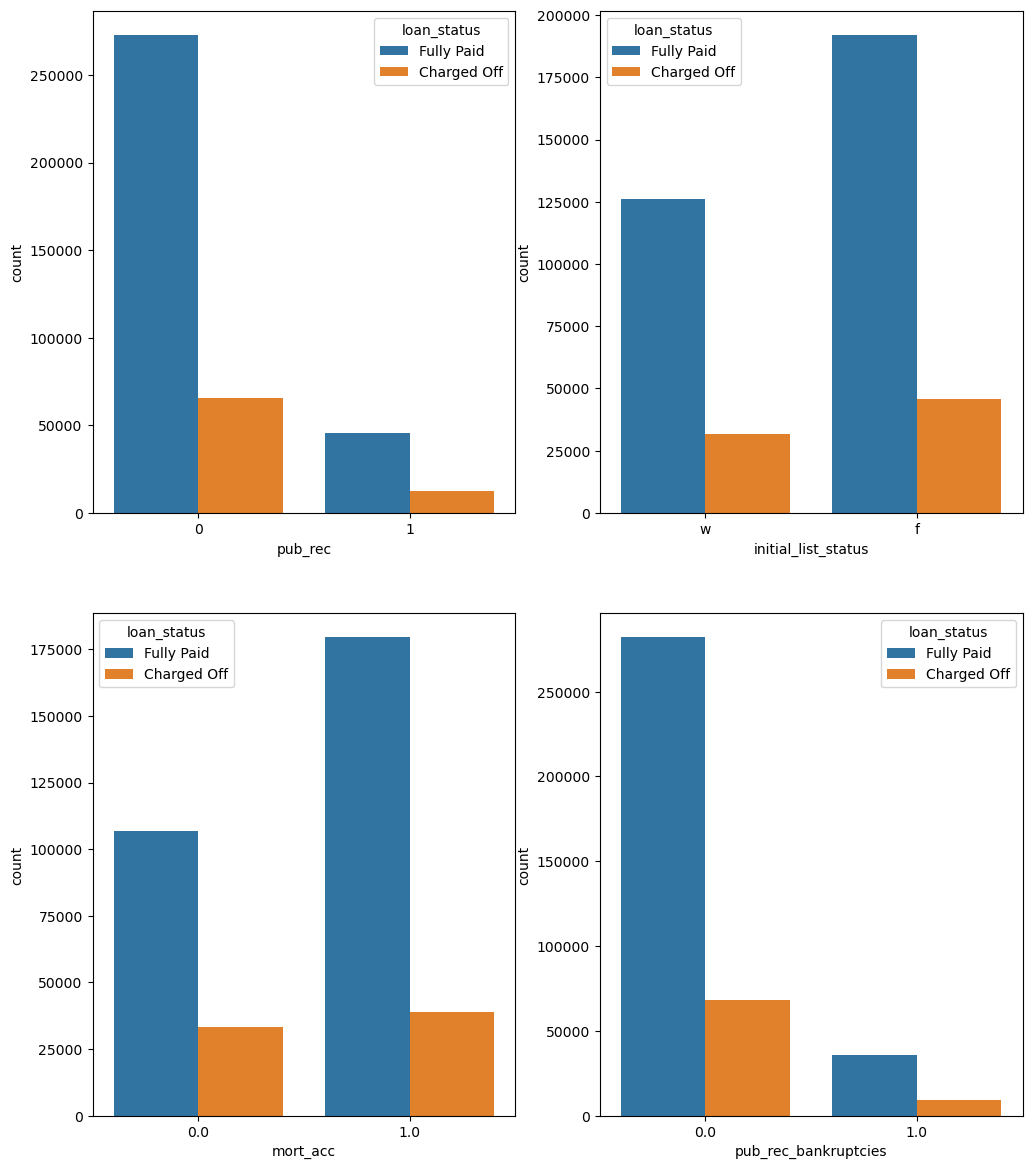

In [155]:
plt.figure(figsize=(12,30))

plt.subplot(4,2,1)
sns.countplot(x='pub_rec',data=df,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='initial_list_status',data=df,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='mort_acc',data=df,hue='loan_status')

plt.subplot(4,2,4)
sns.countplot(x='pub_rec_bankruptcies',data=df,hue='loan_status')

plt.show()


In [156]:
### Data Has no Duplicates
df.duplicated().sum()

np.int64(0)

In [157]:
df['zip_code'] = df['address'].str[-5:]

In [158]:
##### Not processing zip code further as we have only 10 unique values only
df.zip_code.nunique()

10

In [159]:
df.head(2)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,earliest_cr_line_converted,issue_d_converted,vintage_months,zip_code,emp_length_num,term_length_map
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",1990-06-01,2015-01-01,295,22690,10.0,36
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0,20131.0,53.3,27.0,f,INDIVIDUAL,1.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",2004-07-01,2015-01-01,126,05113,4.0,36


#### Outlier treatment. capping outliers with 1.5*IQR on both sides

In [160]:
num_cols = ['loan_amnt','int_rate','installment','dti','annual_inc','open_acc','revol_util','revol_bal','total_acc','vintage_months']
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply capping
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [129]:
df.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [130]:
emp_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length_num'] = df['emp_length'].map(emp_length_mapping)

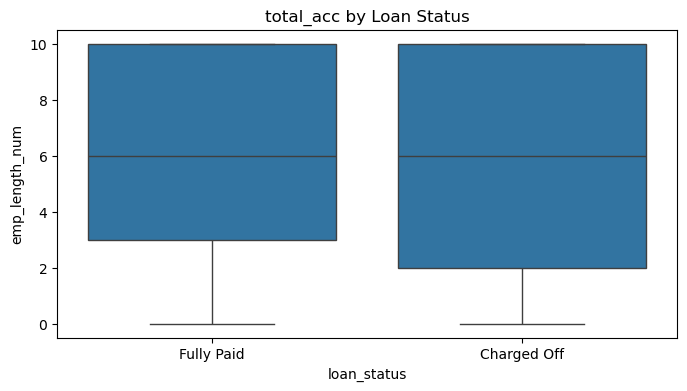

In [132]:
plt.figure(figsize=(8,4))
sns.boxplot(x='loan_status', y='emp_length_num', data=df)
plt.title(f'{col} by Loan Status')
plt.show()

In [141]:
term_length_mapping = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term_length_map'] = df['term'].map(term_length_mapping)

In [142]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

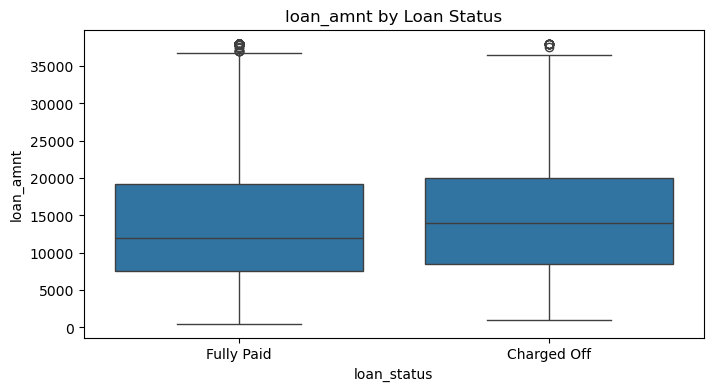

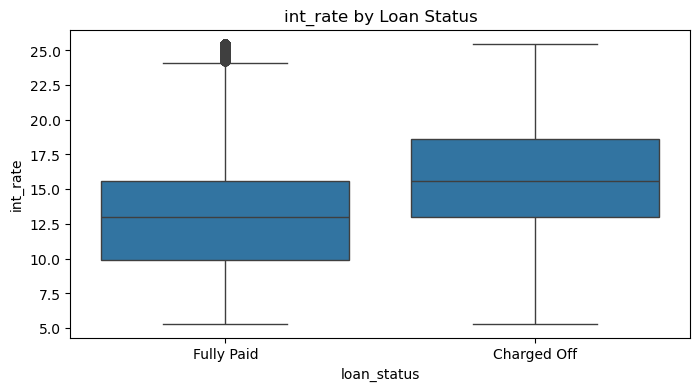

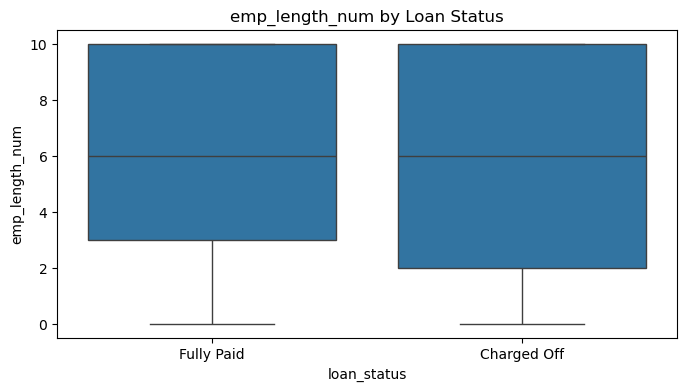

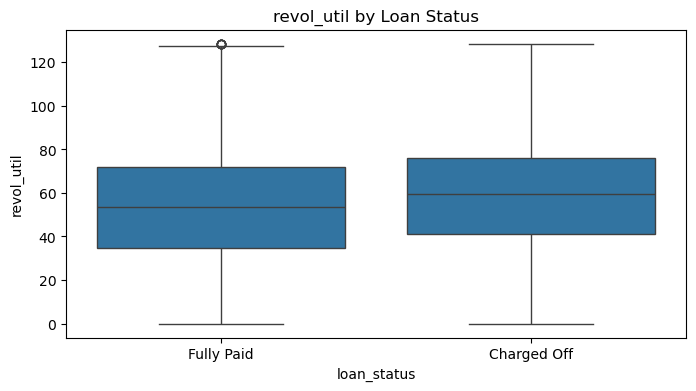

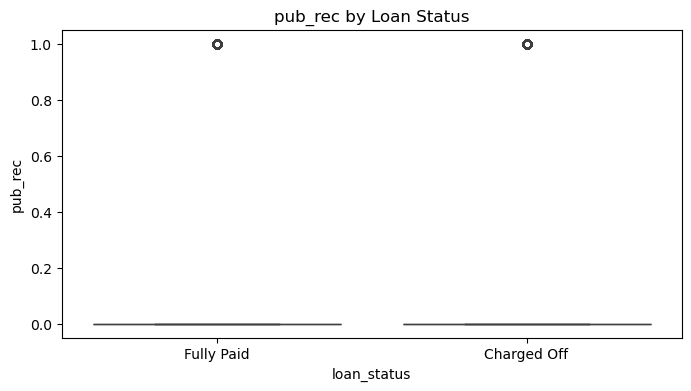

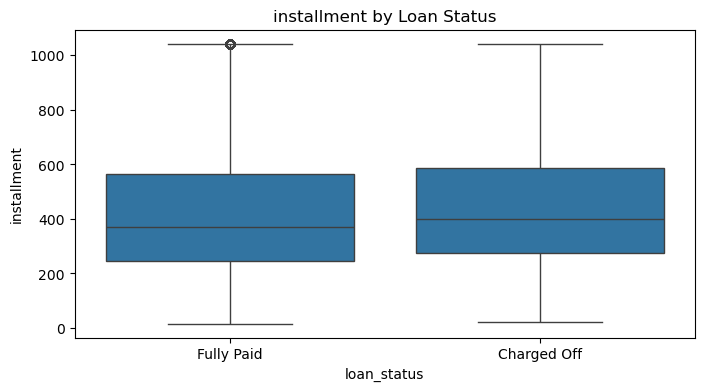

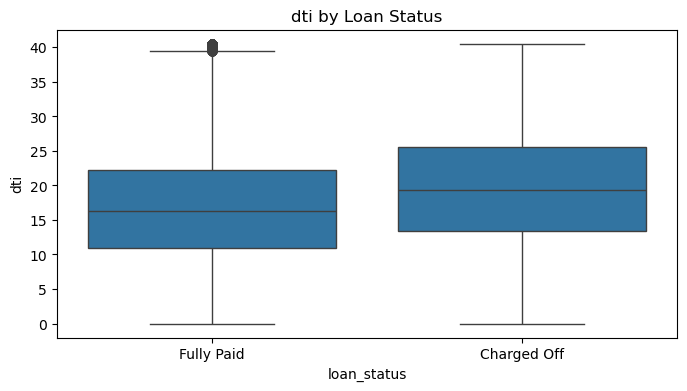

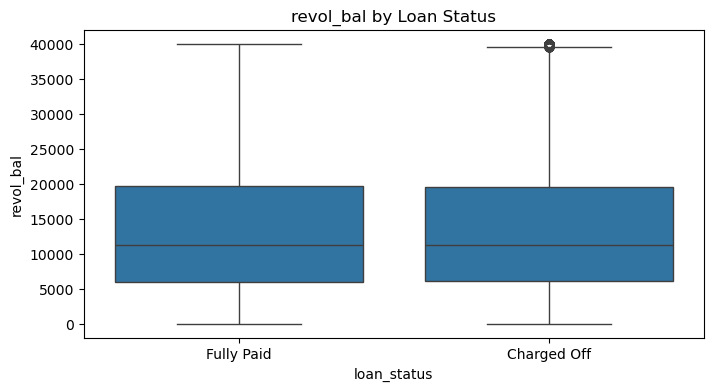

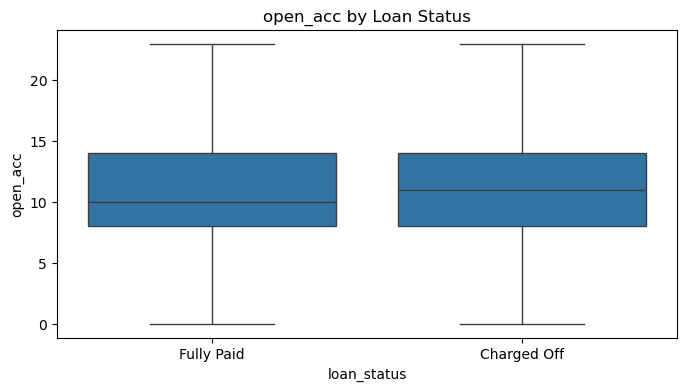

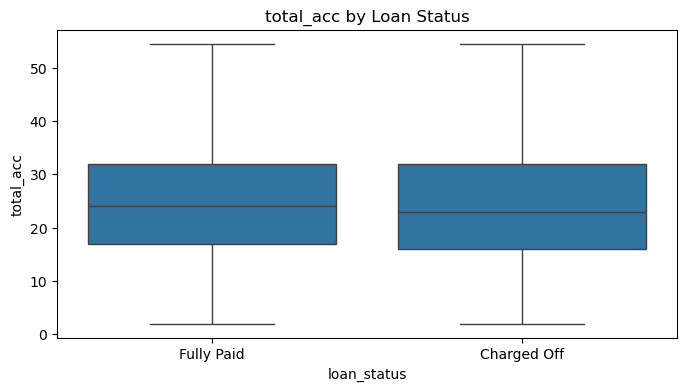

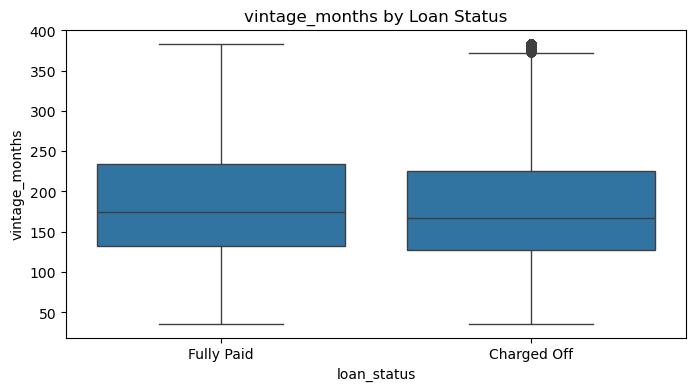

In [180]:
# continuous_vars.append('emp_length_num')
for col in continuous_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f'{col} by Loan Status')
    plt.show()

### Treating Null values

In [184]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,earliest_cr_line_converted,issue_d_converted,vintage_months,zip_code,emp_length_num,term_length_map
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",1990-06-01,2015-01-01,295.0,22690,10.0,36
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0,20131.0,53.3,27.0,f,INDIVIDUAL,1.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",2004-07-01,2015-01-01,126.0,05113,4.0,36
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",2007-08-01,2015-01-01,89.0,05113,0.0,36
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813",2006-09-01,2014-11-01,98.0,00813,6.0,36
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650",1999-03-01,2013-04-01,169.0,11650,9.0,60


In [195]:
df.isna().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                     22927
emp_length                    18301
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
purpose                           0
title                          1756
dti                               0
earliest_cr_line                  0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      276
total_acc                         0
initial_list_status               0
application_type                  0
mort_acc                      37795
pub_rec_bankruptcies            535
address                           0
earliest_cr_line_converted  

In [194]:
### Assuming the mising employment length means an employ with no experience so imputing all the null employ_length_map to zero
df.emp_length_num = df.emp_length_num.fillna(0)

In [203]:
df[df['revol_util'].isna()].head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,earliest_cr_line_converted,issue_d_converted,vintage_months,zip_code,emp_length_num,term_length_map
1686,2150.0,36 months,11.14,70.54,B,B2,ASCD,< 1 year,MORTGAGE,50000.0,Source Verified,Apr-2013,Fully Paid,credit_card,School,6.74,Nov-1996,2.0,0,0.0,NaN,21.0,w,INDIVIDUAL,1.0,0.0,77373 Mendoza Causeway Suite 785\r\nGibsonhave...,1996-11-01,2013-04-01,197.0,00813,0.0,36
3019,5000.0,36 months,13.79,170.38,C,C5,Betty Bacharach Rehabilitation Hospital,< 1 year,RENT,45000.0,Source Verified,Jan-2009,Fully Paid,other,Retainer Fee,6.00,Jul-1994,8.0,0,0.0,NaN,11.0,f,INDIVIDUAL,NaN,0.0,"555 Smith Meadows Apt. 429\r\nBryanfurt, TN 05113",1994-07-01,2009-01-01,174.0,05113,0.0,36
4931,8000.0,36 months,13.67,272.15,B,B5,freight crew,2 years,RENT,30000.0,Source Verified,Dec-2013,Fully Paid,debt_consolidation,Debt consolidation,21.60,Nov-2002,2.0,0,0.0,NaN,15.0,w,INDIVIDUAL,0.0,0.0,"PSC 6735, Box 8380\r\nAPO AE 30723",2002-11-01,2013-12-01,133.0,30723,2.0,36
5382,7000.0,36 months,12.99,235.83,B,B4,Teacher,10+ years,MORTGAGE,61000.0,Verified,Oct-2013,Fully Paid,credit_card,Credit Card Consolidation,28.64,Feb-1991,2.0,0,0.0,NaN,32.0,f,INDIVIDUAL,1.0,0.0,826 Glover Spring Suite 979\r\nNorth Amandashi...,1991-02-01,2013-10-01,272.0,70466,10.0,36
9016,8000.0,36 months,12.12,266.18,B,B3,Federal Bureau of Prisons,3 years,RENT,49000.0,Not Verified,Nov-2012,Fully Paid,debt_consolidation,consolidation loan,20.85,Aug-2003,10.0,0,0.0,NaN,18.0,f,INDIVIDUAL,0.0,0.0,"16908 Taylor Valley Suite 815\r\nBuchananfort,...",2003-08-01,2012-11-01,111.0,48052,3.0,36


In [208]:
df['revol_util'] = np.where(df['revol_util'].isna(),
                            np.where(df['revol_bal']==0,0,df['revol_util']),
                            df['revol_util'])

In [202]:
10000.0/36369.0

0.2749594434820864

In [224]:
df.isna().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                     22926
emp_length                    18300
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
purpose                           0
title                             0
dti                               0
earliest_cr_line                  0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
total_acc                         0
initial_list_status               0
application_type                  0
mort_acc                          0
pub_rec_bankruptcies            535
address                           0
earliest_cr_line_converted  

In [212]:
df.title = df.title.fillna('others')

In [219]:
df['mort_acc'] = df['mort_acc'].fillna(0)


In [225]:
### Removing 53 rows where we cant treat the null values of revol_util column
df = df[~df['revol_util'].isna()]

In [228]:
term_mapping = {' 36 months': 0, ' 60 months': 1}
df['term_length_encoded'] = df['term'].map(term_mapping)

In [300]:
### Using only variables required for training
df_cleaned = df[['loan_amnt','int_rate','sub_grade','home_ownership','annual_inc','verification_status','loan_status','purpose','dti','open_acc','pub_rec','revol_util','pub_rec_bankruptcies','mort_acc','application_type','vintage_months','zip_code','emp_length_num','term_length_encoded']]

In [301]:
df_cleaned['pub_rec_bankruptcies'] = df_cleaned['pub_rec_bankruptcies'].fillna(0)

# Step 1: Map target variable to binary 0/1
df_cleaned['target_binary'] = df_cleaned['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
y = df_cleaned['target_binary']

# Step 2: Define categorical columns to encode


In [302]:
df_cleaned.isna().sum()

loan_amnt               0
int_rate                0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
open_acc                0
pub_rec                 0
revol_util              0
pub_rec_bankruptcies    0
mort_acc                0
application_type        0
vintage_months          0
zip_code                0
emp_length_num          0
term_length_encoded     0
target_binary           0
dtype: int64

In [304]:
df_cleaned.columns

Index(['loan_amnt', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'open_acc',
       'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'mort_acc',
       'application_type', 'vintage_months', 'zip_code', 'emp_length_num',
       'term_length_encoded', 'target_binary'],
      dtype='object')

### One Hot encoding of categorical and standard scaling of numerical variables

In [305]:
categorical_features = ['sub_grade', 'verification_status', 'purpose', 'application_type', 'home_ownership', 'zip_code']
numeric_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 
                    'revol_util', 'pub_rec_bankruptcies', 'mort_acc', 'vintage_months', 
                    'emp_length_num', 'term_length_encoded']

# Step 3: Drop target columns from features
X = df_cleaned.drop(columns=['loan_status', 'target_binary'])

# Step 4: Create ColumnTransformer with OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # keep any other columns as is
)

# Step 5: Fit and transform features
X_encoded = preprocessor.fit_transform(X)

# Optional: Get encoded categorical feature names
cat_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Numeric features remain numeric, in the same order
# Compose full feature names list
feature_names = cat_feature_names + numeric_features

# Optional: Convert to DataFrame for inspection
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)
print(X_encoded_df.head())



   sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           1.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   sub_grade_B2  sub_grade_B3  sub_grade_B4  sub_grade_B5  sub_grade_C1  \
0           0.0           0.0           1.0           0.0           0.0   
1           0.0           0.0           0.0           1.0           0.0   
2           0.0           1.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   sub_grade_C2  sub_grade_C3  sub_grade_C4  sub_grade_C5  sub_grade_D1  \
0           0.0        

In [306]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)




In [307]:
## Apply SMOTE on training data since the data is highly imbalanced
## Using Kfold cross validation
## Define model with regularization L2 regularisation is applied by default
model = LogisticRegression(max_iter=1000, random_state=42)

# Create pipeline combining SMOTE and model
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

# Stratified k-fold with 5 splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation on training data X_train, y_train
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

print(f"Mean ROC-AUC across folds: {scores.mean():.4f}")
print(f"ROC-AUC scores for each fold: {scores}")

Mean ROC-AUC across folds: 0.9056
ROC-AUC scores for each fold: [0.90521954 0.90711276 0.90558927 0.90478401 0.90522004]


### Testing the model

In [311]:
# Fit the pipeline on the entire training data (SMOTE applied internally)
pipeline.fit(X_train, y_train)

# Predict the probability for the positive class on the test set
y_proba_test = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score on the test set
roc_auc_test = roc_auc_score(y_test, y_proba_test)

print(f"ROC-AUC on test set: {roc_auc_test:.4f}")

# get class predictions to calculate other metrics
y_pred_test = pipeline.predict(X_test)

print("Classification Report on Test Set:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, y_pred_test))

ROC-AUC on test set: 0.9060
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87     63663
           1       0.51      0.79      0.62     15533

    accuracy                           0.81     79196
   macro avg       0.73      0.80      0.75     79196
weighted avg       0.86      0.81      0.83     79196

Confusion Matrix on Test Set:
 [[52030 11633]
 [ 3248 12285]]


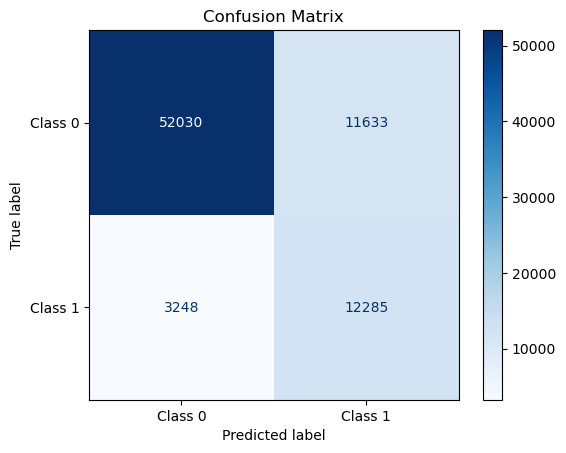

In [312]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix using true and predicted labels
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                               display_labels=['Class 0', 'Class 1'],
                                               cmap='Blues',
                                               values_format='d')

plt.title('Confusion Matrix')
plt.show()

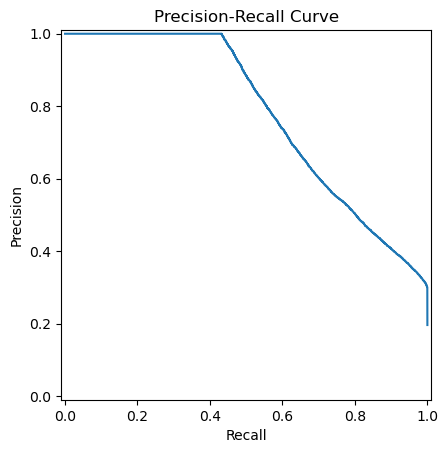

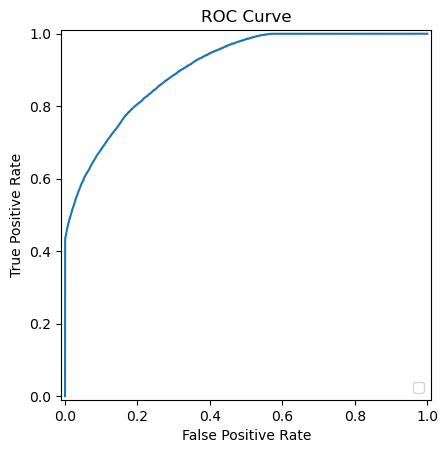

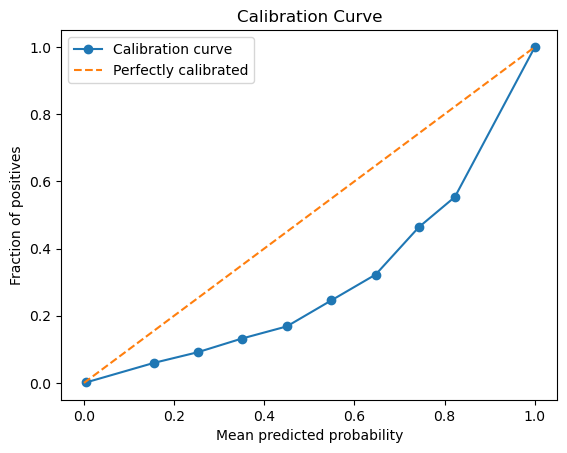

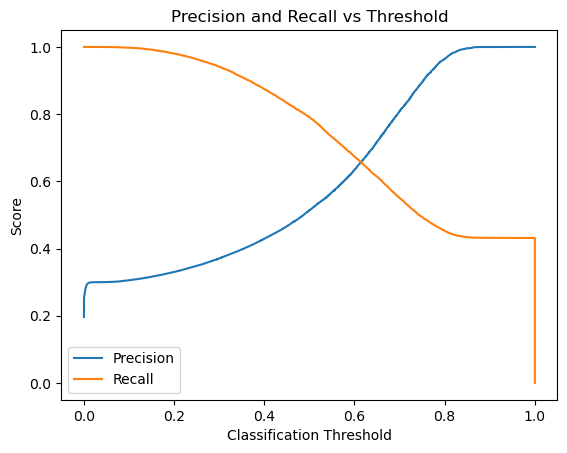

In [316]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, 
    roc_curve, 
    RocCurveDisplay, 
    PrecisionRecallDisplay,
)
from sklearn.calibration import calibration_curve

# Predict probabilities for the positive class

# ---- Precision-Recall Curve ----
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba_test)
disp_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_pr.plot()
plt.title('Precision-Recall Curve')
plt.show()

# ---- ROC Curve ----
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_test)
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
disp_roc.plot()
plt.title('ROC Curve')
plt.show()

# ---- Calibration Curve ----
prob_true, prob_pred = calibration_curve(y_test, y_proba_test, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Curve')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

# ---- Threshold Tuning Example: Precision and Recall at Different Thresholds ----
# Use precision-recall curve thresholds (last threshold set to 1 for plotting)
thresholds_pr = np.append(thresholds_pr, 1.0)

plt.plot(thresholds_pr, precision, label='Precision')
plt.plot(thresholds_pr, recall, label='Recall')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.show()


## Model Evaluation Summary

The logistic regression model with SMOTE shows strong predictive performance on the test set with the following key metrics:

| Metric          | Class 0 (Majority) | Class 1 (Minority) | Overall          |
|-----------------|--------------------|--------------------|------------------|
| **Precision**   | 0.94               | 0.51               | -                |
| **Recall**      | 0.82               | 0.79               | -                |
| **F1-score**    | 0.87               | 0.62               | -                |
| **Support**     | 63,663             | 15,533             | 79,196           |
| **Accuracy**    | -                  | -                  | 0.81             |
| **ROC-AUC**     | \-                 | \-                 | **0.9060**       |

### Confusion Matrix Summary

|                      | Predicted Negative | Predicted Positive |
|----------------------|--------------------|--------------------|
| **Actual Negative**   | 52,030             | 11,633             |
| **Actual Positive**   | 3,248              | 12,285             |

### Interpretation

- The model discriminates well overall, with a high ROC-AUC of 0.906.
- It predicts the majority class (Class 0) with high precision and recall.
- For the minority class (Class 1), the recall is good (0.79), meaning the model correctly identifies most positives, which is important in imbalanced data.
- The precision for Class 1 is moderate (0.51), indicating some false positives.
- Accuracy is 81%, but this should be considered alongside class-specific metrics due to class imbalance.
- Overall, the model performs strongly but could be improved in reducing false positives for the minority class if needed.
---
### Business Interpretation of Model Results
- Strong predictive performance: The model achieves a ROC-AUC of 0.906, indicating it can reliably distinguish between customers who are likely to default (or belong to the positive class) and those who are not. This enables better decision-making for loan approvals, risk management, or targeted interventions.

- High recall for the minority class (~79%): The model successfully identifies a large majority of risky customers, which is critical to minimize potential losses and prevent defaults by flagging high-risk individuals early.

- Moderate precision for minority class (~51%): While many high-risk cases are detected, about half of predicted risky customers may not actually default. This means some caution is needed to balance the cost of false positives — e.g., unnecessarily denying credit or additional verification steps that may inconvenience good customers.

- Majority class predictions are accurate: With high precision and recall for the non-risk group, the model minimizes unnecessary false alarms, allowing smooth processing for low-risk customers.

- Overall accuracy (81%) is good but should be contextualized: Given the imbalanced data, accuracy alone could be misleading, so focus on recall and precision which better reflect business impact.